## PD 7
#### Artur Żółkowski

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.mixture import GaussianMixture

In [2]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

In [4]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(95, 13)
(17, 13)
(17, 14)


In [5]:
X_test_df = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, 0]

In [6]:
train_df

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,12.72,1.75,2.28,22.5,84,1.38,1.76,0.48,1.63,3.300000,0.88,2.42,488
1,13.23,3.30,2.28,18.5,98,1.80,0.83,0.61,1.87,10.520000,0.56,1.51,675
2,12.58,1.29,2.10,20.0,103,1.48,0.58,0.53,1.40,7.600000,0.58,1.55,640
3,12.37,1.17,1.92,19.6,78,2.11,2.00,0.27,1.04,4.680000,1.12,3.48,510
4,13.84,4.12,2.38,19.5,89,1.80,0.83,0.48,1.56,9.010000,0.57,1.64,480
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,12.84,2.96,2.61,24.0,101,2.32,0.60,0.53,0.81,4.920000,0.89,2.15,590
91,12.70,3.87,2.40,23.0,101,2.83,2.55,0.43,1.95,2.570000,1.19,3.13,463
92,12.77,2.39,2.28,19.5,86,1.39,0.51,0.48,0.64,9.899999,0.57,1.63,470
93,12.88,2.99,2.40,20.0,104,1.30,1.22,0.24,0.83,5.400000,0.74,1.42,530


In [11]:
df_all = pd.concat([train_df, val_df, X_test_df])

In [12]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 16
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       129 non-null    float64
 1   Malic acid                    129 non-null    float64
 2   Ash                           129 non-null    float64
 3   Alcalinity of ash             129 non-null    float64
 4   Magnesium                     129 non-null    int64  
 5   Total phenols                 129 non-null    float64
 6   Flavanoids                    129 non-null    float64
 7   Nonflavanoid phenols          129 non-null    float64
 8   Proanthocyanins               129 non-null    float64
 9   Color intensity               129 non-null    float64
 10  Hue                           129 non-null    float64
 11  OD280/OD315 of diluted wines  129 non-null    float64
 12  Proline                       129 non-null    int64  
dtypes: flo

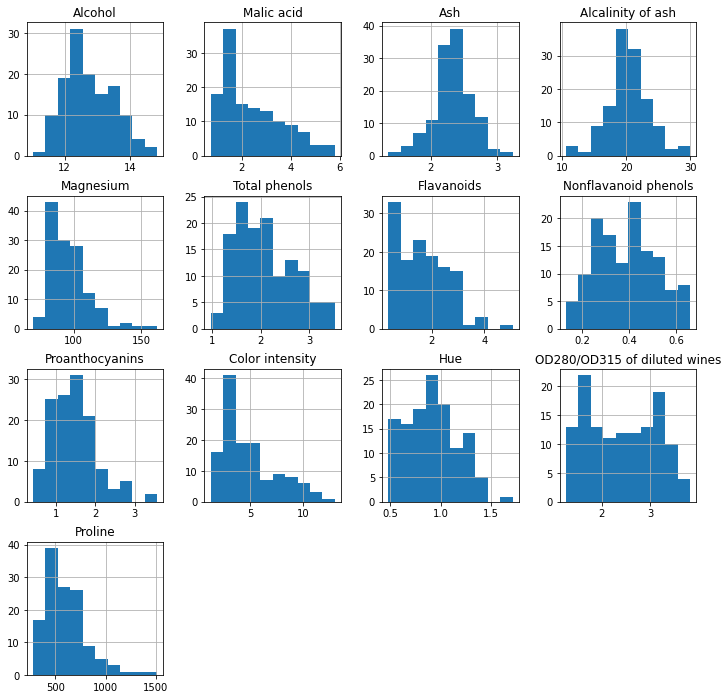

In [14]:
df_all.hist(figsize=(12,12))
plt.show()

### Wykorzystanie GMM do wykrywania próbek odstających

In [15]:
bic = []
for i in range(1, 12):
    gmm_tmp = GaussianMixture(n_components = i, random_state = 42, covariance_type = "full")
    gmm_tmp.fit(train_df)
    bic.append(gmm_tmp.bic(train_df))

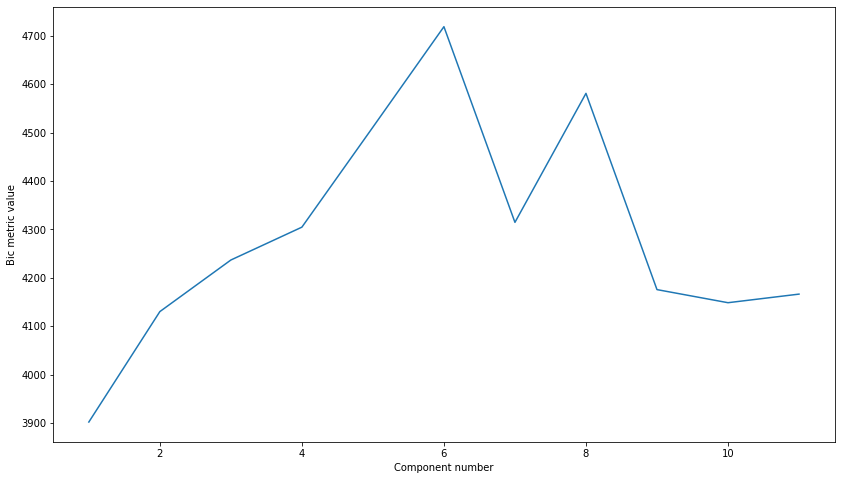

In [18]:
plt.figure(figsize=(14, 8))
plt.plot(range(1, 12), bic)
plt.xlabel("Component number")
plt.ylabel("Bic metric value")
plt.show()

In [19]:
gmm = GaussianMixture(covariance_type='full', n_components=1, random_state=42)
gmm.fit(train_df)

GaussianMixture(random_state=42)

#### Wybór próbek odstających

In [23]:
probs_train = gmm.score_samples(train_df)
probs_val = gmm.score_samples(val_df)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

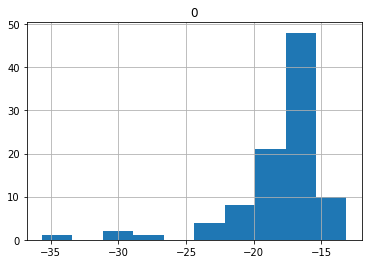

In [24]:
pd.DataFrame(probs_train).hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

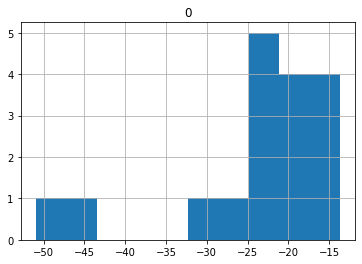

In [25]:
pd.DataFrame(probs_val).hist()

In [28]:
probs = pd.concat([pd.DataFrame(zip(probs_val, ["val"]*len(probs_val))), pd.DataFrame(zip(probs_train, ["train"]*len(probs_train)))])
probs.reset_index(inplace=True, drop=True)
probs.columns = ["prob", "set"]

In [29]:
probs

,prob,set
0,-24.109594,val
1,-13.656306,val
2,-18.348802,val
3,-24.731812,val
4,-26.572217,val
...,...,...
107,-17.185796,train
108,-16.504880,train
109,-17.588148,train
110,-15.767297,train


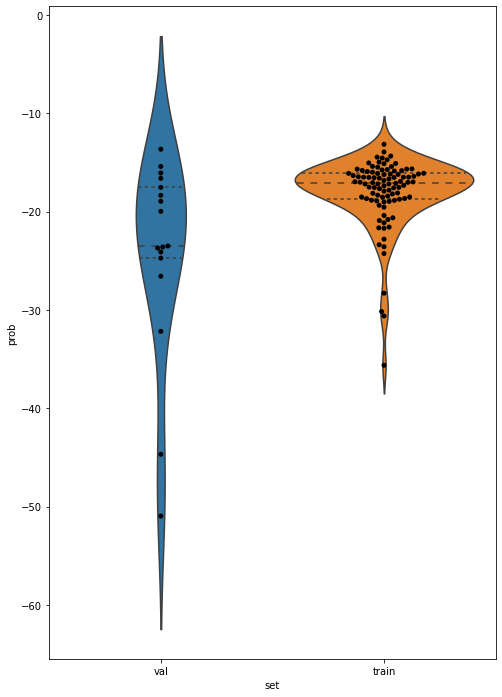

In [35]:
plt.figure(figsize=(8, 12))
sns.violinplot(data = probs, y = "prob", x = "set", inner = "quartiles")
sns.swarmplot(data = probs, y = "prob", x = "set", color = "black")
plt.show()

Bazując na wykresach wybieramy threshold na poziomie -31.

### Sprawdzenie wyników

In [36]:
test_probs = gmm.score_samples(X_test_df)
y_testh = test_probs < -31
y_testh = y_testh.astype(int)

In [39]:
results = pd.DataFrame(
    [("precision", precision_score(y_test, y_testh)),
    ("recall", recall_score(y_test, y_testh)),
    ("F1-score", f1_score(y_test, y_testh))],
    columns=["metric", "value"]
)
results

,metric,value
0,precision,0.833333
1,recall,1.000000
2,F1-score,0.909091
